<a href="https://colab.research.google.com/github/Midgraph/VQGAN-CLIP/blob/main/Batch_Mse_regulized_Modified_VQGANCLIP_zquantize_public.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generates images from text prompts with VQGAN and CLIP (Mse regulized zquantize method).

By jbustter https://twitter.com/jbusted1 .
Based on a notebook by Katherine Crowson (https://github.com/crowsonkb, https://twitter.com/RiversHaveWings)


*Modified by: Justin John*


Expanded with code from Danny Perry's [batch VQGAN processor](https://colab.research.google.com/drive/1sfZIuv8d40dXlPaNBpXgHMwLZ3VkLgnG?usp=sharing#scrollTo=eD4YyZDessWK)  notebook: [@Datamosh](https://instagram.com/datamosh) and [artificial_art_](https://twitter.com/artificial_art_)


*by Max Ingham of [Midgraph](www.midgraph.com) and [@somnai_dreams](https://twitter.com/somnai_dreams)*


In [1]:
#@markdown #**Check GPU type**
#@markdown ### Factory reset runtime if you don't have the desired GPU.

#@markdown ---




#@markdown V100 = Excellent (*Available only for Colab Pro Users*)

#@markdown P100 = Very Good

#@markdown T4 = Good

#@markdown K80 = Meh

#@markdown P4 = Aight

#@markdown ---

!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-90efad9a-62e1-ff15-6eb1-6f49400ede41)


In [2]:
#@markdown #**Anti-Disconnect for Google Colab**
#@markdown ## Run this to stop it from disconnecting automatically 
#@markdown  **(It will anyhow disconnect after 6 - 12 hrs for using the free version of Colab.)**
#@markdown  *(Colab Pro users will get about 24 hrs usage time)*
#@markdown ---

import IPython
js_code = '''
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,60000)
'''
display(IPython.display.Javascript(js_code))

<IPython.core.display.Javascript object>

In [3]:
#@title Connect Google Drive and create folders
#@markdown root_path will be created in `/content/drive/MyDrive/AI/VQGAN_Video`

from google.colab import drive
drive.mount('/content/drive')
root_path = "test" #@param {type: "string"}
abs_root_path = f'/content/drive/MyDrive/AI/VQGAN_Video/{root_path}'

from pathlib import Path
def checkMakePath(filepath):
    make_file = Path(filepath)
    if not make_file.exists():
      !mkdir --parent {make_file}
      print(f'Made {filepath}')
    else:
      print(f'filepath {filepath} exists.')

inDirPath = f'{abs_root_path}/in'
checkMakePath(inDirPath)
outDirPath = f'{abs_root_path}/out'
checkMakePath(outDirPath)
esrOutDirPath = f'{abs_root_path}/esrOut'
checkMakePath(esrOutDirPath)
rendersDirPath = f'{abs_root_path}/renders'
checkMakePath(rendersDirPath)
videoInPath = f'{abs_root_path}/VideoIn'
checkMakePath(videoInPath)


Mounted at /content/drive
Made /content/drive/MyDrive/AI/VQGAN_Video/test/in
Made /content/drive/MyDrive/AI/VQGAN_Video/test/out
Made /content/drive/MyDrive/AI/VQGAN_Video/test/esrOut
Made /content/drive/MyDrive/AI/VQGAN_Video/test/renders
Made /content/drive/MyDrive/AI/VQGAN_Video/test/VideoIn


In [4]:
#@markdown #**Installation of libraries**
# @markdown This cell will take a little while because it has to download several libraries

#@markdown ---

!git clone https://github.com/openai/CLIP
!git clone https://github.com/CompVis/taming-transformers
!pip install ftfy regex tqdm omegaconf pytorch-lightning
!pip install kornia
!pip install einops

Cloning into 'CLIP'...
remote: Enumerating objects: 164, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 164 (delta 33), reused 55 (delta 29), pack-reused 91
Receiving objects: 100% (164/164), 8.91 MiB | 16.90 MiB/s, done.
Resolving deltas: 100% (73/73), done.
Cloning into 'taming-transformers'...
remote: Enumerating objects: 1061, done.
remote: Counting objects: 100% (251/251), done.
remote: Compressing objects: 100% (243/243), done.
remote: Total 1061 (delta 12), reused 229 (delta 7), pack-reused 810
Receiving objects: 100% (1061/1061), 350.33 MiB | 33.19 MiB/s, done.
Resolving deltas: 100% (222/222), done.
     |████████████████████████████████| 64 kB 2.6 MB/s 
     |████████████████████████████████| 74 kB 4.0 MB/s 
     |████████████████████████████████| 925 kB 59.4 MB/s 
     |████████████████████████████████| 596 kB 67.9 MB/s 
     |████████████████████████████████| 112 kB 77.8 MB/s 
     |████████████████████████

     |████████████████████████████████| 336 kB 7.1 MB/s 


In [5]:
#@title Selection of models to download (legacy)
#@markdown By default, the notebook downloads Model 16384 from ImageNet. There are others such as ImageNet 1024, COCO-Stuff, WikiArt 1024, WikiArt 16384, FacesHQ or S-FLCKR, which are not downloaded by default, since it would be in vain if you are not going to use them, so if you want to use them, simply select the models to download.

imagenet_1024 = False #@param {type:"boolean"}
imagenet_16384 = False #@param {type:"boolean"}
coco = False #@param {type:"boolean"}
faceshq = False #@param {type:"boolean"}
wikiart_16384 = False #@param {type:"boolean"}
sflckr = False #@param {type:"boolean"}

if imagenet_1024:
  !curl -L -o vqgan_imagenet_f16_1024.yaml -C - 'https://heibox.uni-heidelberg.de/d/8088892a516d4e3baf92/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' #ImageNet 1024
  !curl -L -o vqgan_imagenet_f16_1024.ckpt -C - 'https://heibox.uni-heidelberg.de/d/8088892a516d4e3baf92/files/?p=%2Fckpts%2Flast.ckpt&dl=1'  #ImageNet 1024
if imagenet_16384:
  !curl -L -o vqgan_imagenet_f16_16384.yaml -C - 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' #ImageNet 16384
  !curl -L -o vqgan_imagenet_f16_16384.ckpt -C - 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fckpts%2Flast.ckpt&dl=1' #ImageNet 16384
if coco:
  !curl -L -o coco.yaml -C - 'https://dl.nmkd.de/ai/clip/coco/coco.yaml' #COCO
  !curl -L -o coco.ckpt -C - 'https://dl.nmkd.de/ai/clip/coco/coco.ckpt' #COCO
if faceshq:
  !curl -L -o faceshq.yaml -C - 'https://drive.google.com/uc?export=download&id=1fHwGx_hnBtC8nsq7hesJvs-Klv-P0gzT' #FacesHQ
  !curl -L -o faceshq.ckpt -C - 'https://app.koofr.net/content/links/a04deec9-0c59-4673-8b37-3d696fe63a5d/files/get/last.ckpt?path=%2F2020-11-13T21-41-45_faceshq_transformer%2Fcheckpoints%2Flast.ckpt' #FacesHQ
if wikiart_16384:
  !curl -L -o wikiart_16384.yaml -C - 'http://eaidata.bmk.sh/data/Wikiart_16384/wikiart_f16_16384_8145600.yaml' #WikiArt 16384
  !curl -L -o wikiart_16384.ckpt -C - 'http://eaidata.bmk.sh/data/Wikiart_16384/wikiart_f16_16384_8145600.ckpt' #WikiArt 16384
if sflckr:
  !curl -L -o sflckr.yaml -C - 'https://heibox.uni-heidelberg.de/d/73487ab6e5314cb5adba/files/?p=%2Fconfigs%2F2020-11-09T13-31-51-project.yaml&dl=1' #S-FLCKR
  !curl -L -o sflckr.ckpt -C - 'https://heibox.uni-heidelberg.de/d/73487ab6e5314cb5adba/files/?p=%2Fcheckpoints%2Flast.ckpt&dl=1' #S-FLCKR

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   692  100   692    0     0    789      0 --:--:-- --:--:-- --:--:--   789
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  934M  100  934M    0     0  14.7M      0  0:01:03  0:01:03 --:--:-- 14.9M


In [71]:
#@markdown #**Loading libraries and definitions**

import argparse
import math
from pathlib import Path
import sys
import os
from IPython.display import clear_output 

sys.path.append('./taming-transformers')

from IPython import display
from omegaconf import OmegaConf
from PIL import Image
from taming.models import cond_transformer, vqgan
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm
import numpy as np

from CLIP import clip

import kornia.augmentation as K

def noise_gen(shape):
    n, c, h, w = shape
    noise = torch.zeros([n, c, 1, 1])
    for i in reversed(range(5)):
        h_cur, w_cur = h // 2**i, w // 2**i
        noise = F.interpolate(noise, (h_cur, w_cur), mode='bicubic', align_corners=False)
        noise += torch.randn([n, c, h_cur, w_cur]) / 5
    return noise


def sinc(x):
    return torch.where(x != 0, torch.sin(math.pi * x) / (math.pi * x), x.new_ones([]))


def lanczos(x, a):
    cond = torch.logical_and(-a < x, x < a)
    out = torch.where(cond, sinc(x) * sinc(x/a), x.new_zeros([]))
    return out / out.sum()


def ramp(ratio, width):
    n = math.ceil(width / ratio + 1)
    out = torch.empty([n])
    cur = 0
    for i in range(out.shape[0]):
        out[i] = cur
        cur += ratio
    return torch.cat([-out[1:].flip([0]), out])[1:-1]


def resample(input, size, align_corners=True):
    n, c, h, w = input.shape
    dh, dw = size

    input = input.view([n * c, 1, h, w])

    if dh < h:
        kernel_h = lanczos(ramp(dh / h, 2), 2).to(input.device, input.dtype)
        pad_h = (kernel_h.shape[0] - 1) // 2
        input = F.pad(input, (0, 0, pad_h, pad_h), 'reflect')
        input = F.conv2d(input, kernel_h[None, None, :, None])

    if dw < w:
        kernel_w = lanczos(ramp(dw / w, 2), 2).to(input.device, input.dtype)
        pad_w = (kernel_w.shape[0] - 1) // 2
        input = F.pad(input, (pad_w, pad_w, 0, 0), 'reflect')
        input = F.conv2d(input, kernel_w[None, None, None, :])

    input = input.view([n, c, h, w])
    return F.interpolate(input, size, mode='bicubic', align_corners=align_corners)
    

# def replace_grad(fake, real):
#     return fake.detach() - real.detach() + real


class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward

    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)


class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)

    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None

replace_grad = ReplaceGrad.apply

clamp_with_grad = ClampWithGrad.apply
# clamp_with_grad = torch.clamp

def vector_quantize(x, codebook):
    d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
    indices = d.argmin(-1)
    x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
    return replace_grad(x_q, x)


class Prompt(nn.Module):
    def __init__(self, embed, weight=1., stop=float('-inf')):
        super().__init__()
        self.register_buffer('embed', embed)
        self.register_buffer('weight', torch.as_tensor(weight))
        self.register_buffer('stop', torch.as_tensor(stop))

    def forward(self, input):
        
        input_normed = F.normalize(input.unsqueeze(1), dim=2)#(input / input.norm(dim=-1, keepdim=True)).unsqueeze(1)# 
        embed_normed = F.normalize((self.embed).unsqueeze(0), dim=2)#(self.embed / self.embed.norm(dim=-1, keepdim=True)).unsqueeze(0)#

        dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
        dists = dists * self.weight.sign()
        return self.weight.abs() * replace_grad(dists, torch.maximum(dists, self.stop)).mean()


def parse_prompt(prompt):
    vals = prompt.rsplit(':', 2)
    vals = vals + ['', '1', '-inf'][len(vals):]
    return vals[0], float(vals[1]), float(vals[2])

def one_sided_clip_loss(input, target, labels=None, logit_scale=100):
    input_normed = F.normalize(input, dim=-1)
    target_normed = F.normalize(target, dim=-1)
    logits = input_normed @ target_normed.T * logit_scale
    if labels is None:
        labels = torch.arange(len(input), device=logits.device)
    return F.cross_entropy(logits, labels)

class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow

        self.av_pool = nn.AdaptiveAvgPool2d((self.cut_size, self.cut_size))
        self.max_pool = nn.AdaptiveMaxPool2d((self.cut_size, self.cut_size))

    def set_cut_pow(self, cut_pow):
      self.cut_pow = cut_pow

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        cutouts_full = []
        
        min_size_width = min(sideX, sideY)
        lower_bound = float(self.cut_size/min_size_width)
        
        for ii in range(self.cutn):
            
            
          # size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
          size = int(min_size_width*torch.zeros(1,).normal_(mean=.8, std=.3).clip(lower_bound, 1.)) # replace .5 with a result for 224 the default large size is .95
          # size = int(min_size_width*torch.zeros(1,).normal_(mean=.9, std=.3).clip(lower_bound, .95)) # replace .5 with a result for 224 the default large size is .95

          offsetx = torch.randint(0, sideX - size + 1, ())
          offsety = torch.randint(0, sideY - size + 1, ())
          cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
          cutouts.append(resample(cutout, (self.cut_size, self.cut_size)))

        
        cutouts = torch.cat(cutouts, dim=0)

        # if args.use_augs:
        #   cutouts = augs(cutouts)

        # if args.noise_fac:
        #   facs = cutouts.new_empty([cutouts.shape[0], 1, 1, 1]).uniform_(0, args.noise_fac)
        #   cutouts = cutouts + facs * torch.randn_like(cutouts)
        

        return clamp_with_grad(cutouts, 0, 1)


def load_vqgan_model(config_path, checkpoint_path):
    config = OmegaConf.load(config_path)
    if config.model.target == 'taming.models.vqgan.VQModel':
        model = vqgan.VQModel(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.cond_transformer.Net2NetTransformer':
        parent_model = cond_transformer.Net2NetTransformer(**config.model.params)
        parent_model.eval().requires_grad_(False)
        parent_model.init_from_ckpt(checkpoint_path)
        model = parent_model.first_stage_model
    elif config.model.target == 'taming.models.vqgan.GumbelVQ':
        model = vqgan.GumbelVQ(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    else:
        raise ValueError(f'unknown model type: {config.model.target}')
    del model.loss
    return model

def resize_image(image, out_size):
    ratio = image.size[0] / image.size[1]
    area = min(image.size[0] * image.size[1], out_size[0] * out_size[1])
    size = round((area * ratio)**0.5), round((area / ratio)**0.5)
    return image.resize(size, Image.LANCZOS)

class TVLoss(nn.Module):
    def forward(self, input):
        input = F.pad(input, (0, 1, 0, 1), 'replicate')
        x_diff = input[..., :-1, 1:] - input[..., :-1, :-1]
        y_diff = input[..., 1:, :-1] - input[..., :-1, :-1]
        diff = x_diff**2 + y_diff**2 + 1e-8
        return diff.mean(dim=1).sqrt().mean()

class GaussianBlur2d(nn.Module):
    def __init__(self, sigma, window=0, mode='reflect', value=0):
        super().__init__()
        self.mode = mode
        self.value = value
        if not window:
            window = max(math.ceil((sigma * 6 + 1) / 2) * 2 - 1, 3)
        if sigma:
            kernel = torch.exp(-(torch.arange(window) - window // 2)**2 / 2 / sigma**2)
            kernel /= kernel.sum()
        else:
            kernel = torch.ones([1])
        self.register_buffer('kernel', kernel)

    def forward(self, input):
        n, c, h, w = input.shape
        input = input.view([n * c, 1, h, w])
        start_pad = (self.kernel.shape[0] - 1) // 2
        end_pad = self.kernel.shape[0] // 2
        input = F.pad(input, (start_pad, end_pad, start_pad, end_pad), self.mode, self.value)
        input = F.conv2d(input, self.kernel[None, None, None, :])
        input = F.conv2d(input, self.kernel[None, None, :, None])
        return input.view([n, c, h, w])

class EMATensor(nn.Module):
    """implmeneted by Katherine Crowson"""
    def __init__(self, tensor, decay):
        super().__init__()
        self.tensor = nn.Parameter(tensor)
        self.register_buffer('biased', torch.zeros_like(tensor))
        self.register_buffer('average', torch.zeros_like(tensor))
        self.decay = decay
        self.register_buffer('accum', torch.tensor(1.))
        self.update()
    
    @torch.no_grad()
    def update(self):
        if not self.training:
            raise RuntimeError('update() should only be called during training')

        self.accum *= self.decay
        self.biased.mul_(self.decay)
        self.biased.add_((1 - self.decay) * self.tensor)
        self.average.copy_(self.biased)
        self.average.div_(1 - self.accum)

    def forward(self):
        if self.training:
            return self.tensor
        return self.average

%mkdir /content/vids

mkdir: cannot create directory ‘/content/vids’: File exists


In [51]:
#@markdown #**Split video into images - FFmpeg**
#@markdown Upload your video to the folder `{projectDir}/VideoIn` and enter the name below and run the cell.

#@markdown  You can skip this step by uploading your png images to `root_path/in` (specified above). Name each frame in-0000.png in ascending order. 


from subprocess import Popen, PIPE
input_video='summoner_twitter.mp4' #@param{type:"string"}
if os.path.isfile(f'{videoInPath}/{input_video}'):
  print('Video exists! Processing...') 
  p = Popen(['ffmpeg', '-y', '-i', f'{videoInPath}/{input_video}', '-qscale:', '2', f'{inDirPath}/in-%04d.png'], stdin=PIPE)
  print('Processing complete') 
else:
  print('WARNING: Video file not found.') 

Video exists! Processing...
Processing complete


## **Arguments**         

In [125]:
#@markdown #**Settings and inputs**
#@markdown Double-click here for more indepth settings
#@markdown First time you select a new VQGAN Model, this cell will download it.
#@markdown  
#@markdown  .

prompts=["a beautiful realistic painting by Cedric Peyravernay of a summoning ritual, with a lot of wide textured brush strokes, trending on artstation,"]#@param{type:"raw"}
size=[600, 600] #@param{type:"raw"}
# init_image= '/content/wMsuAbPmE8SMgAAAABJRU5ErkJggg.png' #@param{type:"string"}
init_weight= 1 #@param{type:"raw"}
step_size = 0.07 #@param {type:"slider", min:0, max:1, step:0.01}


model_id = "vqgan_imagenet_f16_16384" #@param ["vqgan_imagenet_f16_16384", "vqgan_imagenet_f16_1024", "wikiart_1024", "wikiart_16384", "coco", "faceshq", "sflckr"]


# cutouts / crops
cutn=64 #@param{type:"raw"}
cut_pow=1 #@param{type:"raw"}

display_freq=10 #@param{type:"raw"}
seed=12343425 #@param{type:"raw"}
use_augs = True #@param{type:"boolean"}
max_itter=50 #@param{type:"raw"}


model_names={"vqgan_imagenet_f16_16384": 'ImageNet 16384',"vqgan_imagenet_f16_1024":"ImageNet 1024", 
          "wikiart_1024":"WikiArt 1024", "wikiart_16384":"WikiArt 16384", "coco":"COCO-Stuff", 
          "drive/MyDrive/colab/coco":"COCO-Stuff (Local)","faceshq":"FacesHQ", "sflckr":"S-FLCKR"}
model_name = model_names[model_id]  

if model_id == 'vqgan_imagenet_f16_1024':
  !curl -L -o vqgan_imagenet_f16_1024.yaml -C - 'https://heibox.uni-heidelberg.de/d/8088892a516d4e3baf92/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' #ImageNet 1024
  !curl -L -o vqgan_imagenet_f16_1024.ckpt -C - 'https://heibox.uni-heidelberg.de/d/8088892a516d4e3baf92/files/?p=%2Fckpts%2Flast.ckpt&dl=1'  #ImageNet 1024
if model_id == 'vqgan_imagenet_f16_16384':
  !curl -L -o vqgan_imagenet_f16_16384.yaml -C - 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' #ImageNet 16384
  !curl -L -o vqgan_imagenet_f16_16384.ckpt -C - 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fckpts%2Flast.ckpt&dl=1' #ImageNet 16384
if model_id == 'coco':
  !curl -L -o coco.yaml -C - 'https://dl.nmkd.de/ai/clip/coco/coco.yaml' #COCO
  !curl -L -o coco.ckpt -C - 'https://dl.nmkd.de/ai/clip/coco/coco.ckpt' #COCO
if model_id == 'faceshq':
  !curl -L -o faceshq.yaml -C - 'https://drive.google.com/uc?export=download&id=1fHwGx_hnBtC8nsq7hesJvs-Klv-P0gzT' #FacesHQ
  !curl -L -o faceshq.ckpt -C - 'https://app.koofr.net/content/links/a04deec9-0c59-4673-8b37-3d696fe63a5d/files/get/last.ckpt?path=%2F2020-11-13T21-41-45_faceshq_transformer%2Fcheckpoints%2Flast.ckpt' #FacesHQ
if model_id == 'wikiart_16384':
  !curl -L -o wikiart_16384.yaml -C - 'http://eaidata.bmk.sh/data/Wikiart_16384/wikiart_f16_16384_8145600.yaml' #WikiArt 16384
  !curl -L -o wikiart_16384.ckpt -C - 'http://eaidata.bmk.sh/data/Wikiart_16384/wikiart_f16_16384_8145600.ckpt' #WikiArt 16384
if model_id == 'sflckr':
  !curl -L -o sflckr.yaml -C - 'https://heibox.uni-heidelberg.de/d/73487ab6e5314cb5adba/files/?p=%2Fconfigs%2F2020-11-09T13-31-51-project.yaml&dl=1' #S-FLCKR
  !curl -L -o sflckr.ckpt -C - 'https://heibox.uni-heidelberg.de/d/73487ab6e5314cb5adba/files/?p=%2Fcheckpoints%2Flast.ckpt&dl=1' #S-FLCKR


args = argparse.Namespace(
    
    prompts=prompts,
    size=size, 
    init_image= '/content/image (2).png',
    init_weight= 0,

    # clip model settings
    clip_model='ViT-B/32',
    vqgan_config=f'{model_id}.yaml',
    vqgan_checkpoint=f'{model_id}.ckpt',
    step_size=step_size,
    
    # cutouts / crops
    cutn=64,
    cut_pow=1,

    # display
    display_freq= display_freq,
    seed= seed,
    use_augs= use_augs,
    noise_fac= 0.1,
    ema_val = 0.99,

    record_generation=True,

    # noise and other constraints
    use_noise = None,
    constraint_regions = False,#
    
    
    # add noise to embedding
    noise_prompt_weights = None,
    noise_prompt_seeds = [14575],#

    # mse settings
    mse_withzeros = True,
    mse_decay_rate = 50,
    mse_epoches = 5,
    mse_quantize = True,

    # end itteration
    max_itter = max_itter,
)

mse_decay = 0
if args.init_weight:
  mse_decay = args.init_weight / args.mse_epoches

# <AUGMENTATIONS>
augs = nn.Sequential(
    
    K.RandomHorizontalFlip(p=0.5),
    K.RandomAffine(degrees=30, translate=0.1, p=0.8, padding_mode='border'), # padding_mode=2
    K.RandomPerspective(0.2,p=0.4, ),
    K.ColorJitter(hue=0.01, saturation=0.01, p=0.7),

    )

noise = noise_gen([1, 3, args.size[0], args.size[1]])
image = TF.to_pil_image(noise.div(5).add(0.5).clamp(0, 1)[0])
image.save('init3.png')

!echo "{prompts_str}" > {abs_root_path}/prompt.txt

** Resuming transfer from byte position 692
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
** Resuming transfer from byte position 980092370
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
/bin/bash: {abs_root_path}/prompt.txt: No such file or directory


# **Advanced: Constraints**

In [ ]:
#@markdown #*Double-click here and edit me if you like*
#@markdown ---

from PIL import Image, ImageDraw

if args.constraint_regions and args.init_image:
  
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

  toksX, toksY = args.size[0] // 16, args.size[1] // 16

  pil_image = Image.open(args.init_image).convert('RGB')
  pil_image = pil_image.resize((toksX * 16, toksY * 16), Image.LANCZOS)

  width, height = pil_image.size

  d = ImageDraw.Draw(pil_image)
  for i in range(0,width,16):
      d.text((i+4,0), f"{int(i/16)}", fill=(50,200,100))
  for i in range(0,height,16):
      d.text((4,i), f"{int(i/16)}", fill=(50,200,100))

  pil_image = TF.to_tensor(pil_image)

  print(pil_image.shape)
  for i in range(pil_image.shape[1]):
    for j in range(pil_image.shape[2]):
      if i%16 == 0 or j%16 ==0:
        pil_image[:,i,j] = 0

  # select region
  c_h = [16,32]
  c_w = [0,40]

  c_hf = [i*16 for i in c_h]
  c_wf = [i*16 for i in c_w]

  pil_image[0,c_hf[0]:c_hf[1],c_wf[0]:c_wf[1]] = 0

  TF.to_pil_image(pil_image.cpu()).save('progress.png')
  display.display(display.Image('progress.png'))

  z_mask = torch.zeros([1, 256, int(height/16), int(width/16)]).to(device)
  z_mask[:,:,c_h[0]:c_h[1],c_w[0]:c_w[1]] = 1

In [56]:
#@markdown Double check correct framecount. Slicing video and registering large amounts of files in google drive can sometimes fall out of sync.

files = os.listdir(f'{abs_root_path}/in')
print(f'{len(files)} Frames in the animation')

921 Frames in the animation


#**Final Steps**

Starting Frame: 0008
Using seed: 12343425


0it [00:00, ?it/s]

i: 0, loss: 0.979467, losses: 0.979467


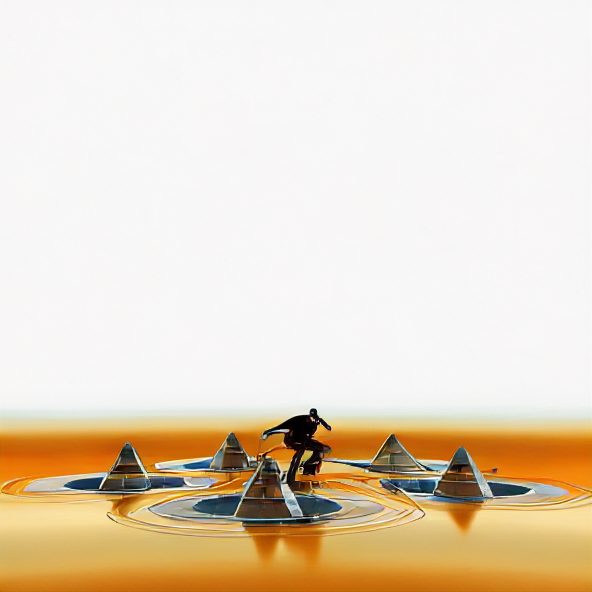

i: 10, loss: 0.907213, losses: 0.907213


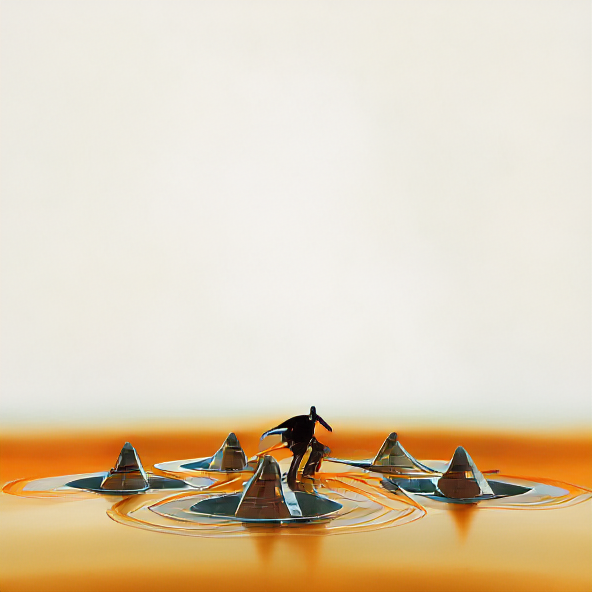

i: 20, loss: 0.857468, losses: 0.857468


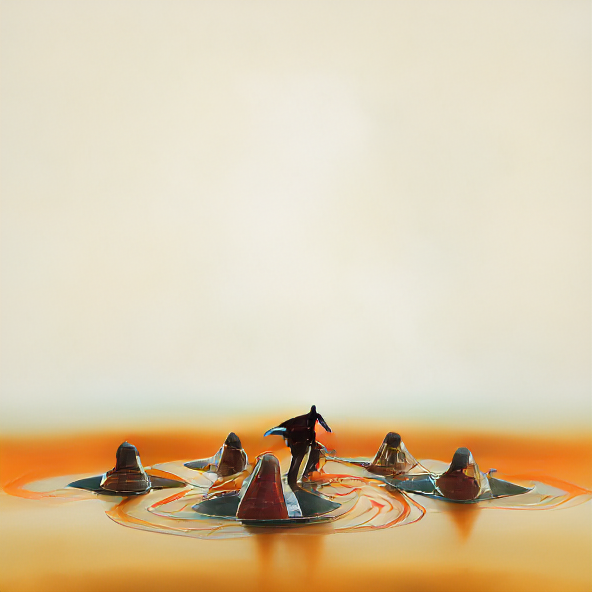

In [ ]:
#@markdown #**Fire up the AI**

#@markdown ---

files = os.listdir(f'{abs_root_path}/in')
print(f'{len(files)} Frames in the animation')
amount_of_frames = len(files)
batchNum = 1;
# iterationCount = starting_iterations


##IGNORE BELOW##

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print('Using device:', device)
print('using prompts: ', args.prompts)

tv_loss = TVLoss() 

model = load_vqgan_model(args.vqgan_config, args.vqgan_checkpoint).to(device)
perceptor = clip.load(args.clip_model, jit=False)[0].eval().requires_grad_(False).to(device)
mse_weight = args.init_weight

cut_size = perceptor.visual.input_resolution
# e_dim = model.quantize.e_dim

if args.vqgan_checkpoint == 'vqgan_openimages_f16_8192.ckpt':
    e_dim = 256
    n_toks = model.quantize.n_embed
    z_min = model.quantize.embed.weight.min(dim=0).values[None, :, None, None]
    z_max = model.quantize.embed.weight.max(dim=0).values[None, :, None, None]
else:
    e_dim = model.quantize.e_dim
    n_toks = model.quantize.n_e
    z_min = model.quantize.embedding.weight.min(dim=0).values[None, :, None, None]
    z_max = model.quantize.embedding.weight.max(dim=0).values[None, :, None, None]


make_cutouts = MakeCutouts(cut_size, args.cutn, cut_pow=args.cut_pow)

f = 2**(model.decoder.num_resolutions - 1)
toksX, toksY = args.size[0] // f, args.size[1] // f

normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                 std=[0.26862954, 0.26130258, 0.27577711])

##IGNORE ABOVE##




pMs = []

if args.noise_prompt_weights and args.noise_prompt_seeds:
  for seed, weight in zip(args.noise_prompt_seeds, args.noise_prompt_weights):
    gen = torch.Generator().manual_seed(seed)
    embed = torch.empty([1, perceptor.visual.output_dim]).normal_(generator=gen)
    pMs.append(Prompt(embed, weight).to(device))

for prompt in args.prompts:
    txt, weight, stop = parse_prompt(prompt)
    embed = perceptor.encode_text(clip.tokenize(txt).to(device)).float()
    pMs.append(Prompt(embed, weight, stop).to(device))
    # pMs[0].embed = pMs[0].embed + Prompt(embed, weight, stop).embed.to(device)


def synth(z, quantize=True):
    if args.constraint_regions:
      z = replace_grad(z, z * z_mask)

    if quantize:
      if args.vqgan_checkpoint == 'vqgan_openimages_f16_8192.ckpt':
        z_q = vector_quantize(z.movedim(1, 3), model.quantize.embed.weight).movedim(3, 1)
      else:
        z_q = vector_quantize(z.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)

    else:
      z_q = z.model

    return clamp_with_grad(model.decode(z_q).add(1).div(2), 0, 1)

@torch.no_grad()
def checkin(i, losses):
    losses_str = ', '.join(f'{loss.item():g}' for loss in losses)
    tqdm.write(f'i: {i}, loss: {sum(losses).item():g}, losses: {losses_str}')
    out = synth(z.average, True)

    TF.to_pil_image(out[0].cpu()).save('progress.png')   
    display.display(display.Image('progress.png')) 


def ascend_txt():
    global mse_weight

    out = synth(z.tensor)

    if args.record_generation:
      with torch.no_grad():
        global vid_index
        out_a = synth(z.average, True)
        TF.to_pil_image(out_a[0].cpu()).save(f'/content/vids/{vid_index}.png')
        vid_index += 1

    cutouts = make_cutouts(out)

    if args.use_augs:
      cutouts = augs(cutouts)

    if args.noise_fac:
      facs = cutouts.new_empty([args.cutn, 1, 1, 1]).uniform_(0, args.noise_fac)
      cutouts = cutouts + facs * torch.randn_like(cutouts)

    iii = perceptor.encode_image(normalize(cutouts)).float()

    result = []

    if args.init_weight:
        
        global z_orig
        
        result.append(F.mse_loss(z.tensor, z_orig) * mse_weight / 2)
        # result.append(F.mse_loss(z, z_orig) * ((1/torch.tensor((i)*2 + 1))*mse_weight) / 2)

        with torch.no_grad():
          if i > 0 and i%args.mse_decay_rate==0 and i <= args.mse_decay_rate*args.mse_epoches:

            if args.mse_quantize:
              z_orig = vector_quantize(z.average.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)#z.average
            else:
              z_orig = z.average.clone()

            if mse_weight - mse_decay > 0 and mse_weight - mse_decay >= mse_decay:
              mse_weight = mse_weight - mse_decay
              print(f"updated mse weight: {mse_weight}")
            else:
              mse_weight = 0
              print(f"updated mse weight: {mse_weight}")

    for prompt in pMs:
        result.append(prompt(iii))

    return result

vid_index = 0
def train(i):
    
    opt.zero_grad()
    lossAll = ascend_txt()

    if i % args.display_freq == 0:
        checkin(i, lossAll)
    
    loss = sum(lossAll)

    loss.backward()
    opt.step()
    z.update()

def save_final(s):
    print('saving')
    global i
    out = synth(z.average, True)

    filename = f"{outDirPath}/out-{batchNum:04}.png"
    TF.to_pil_image(out[0].cpu()).save(filename)


def run_seed():
  torch.cuda.empty_cache()
  
 

  i = 0
  with tqdm() as pbar:
      while True and i != args.max_itter:

          train(i)

          if i > 0 and i%args.mse_decay_rate==0 and i <= args.mse_decay_rate * args.mse_epoches:
            z = EMATensor(z.average, args.ema_val)
            opt = optim.Adam(z.parameters(), lr=args.step_size, weight_decay=0.00000000)

          i += 1
          pbar.update()
      print('run finished')


try:
    while amount_of_frames > 0:
        clear_output(wait=True)
        print(f'Starting Frame: {batchNum:04}')

        filenameIn = f"{inDirPath}/in-{batchNum:04}.png"
       
        if args.seed is not None:
            torch.manual_seed(args.seed)

        pil_image = Image.open(filenameIn).convert('RGB')
        pil_image = pil_image.resize((toksX * 16, toksY * 16), Image.LANCZOS)
        pil_image = TF.to_tensor(pil_image)
        if args.use_noise:
          pil_image = pil_image + args.use_noise * torch.randn_like(pil_image) 
        z, *_ = model.encode(pil_image.to(device).unsqueeze(0) * 2 - 1)


        z = EMATensor(z, args.ema_val)

        z_orig = z.tensor.clone()

        opt = optim.Adam(z.parameters(), lr=args.step_size, weight_decay=0.00000000)


        s = args.seed
        torch.manual_seed(1)
        print('Using seed:', s)
        # if batchNum != 1:
        #   loadImgPrompts()
        run_seed()
        save_final(s)
        batchNum += 1;
        # if iterationCount < max_iterations:
        #   if batchNum % increase_every_frame == 0:
        #     iterationCount += increase_iterations
        # if batchNum == switch_at_frame:
        #     iterationCount += add_iteration_switch
        amount_of_frames -= 1

except KeyboardInterrupt:
    pass


# Upscale images ESRGAN


In [ ]:
#@title Install ESRGAN

def installESRGAN():
  print("Installing libraries for Real-ESRGAN upscaling.")
  !git clone https://github.com/xinntao/Real-ESRGAN.git
  %cd Real-ESRGAN
  !pip install basicsr
  !pip install facexlib
  !pip install gfpgan
  !pip install -r requirements.txt
  !python setup.py develop
  # Download the pre-trained model(s)
  !wget https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth -P experiments/pretrained_models
  !wget https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.2.4/RealESRGAN_x4plus_anime_6B.pth -P experiments/pretrained_models
  !wget https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.1/RealESRGAN_x2plus.pth -P experiments/pretrained_models
  print("Finished Installing libraries for Real-ESRGAN upscaling.")
  %cd ..

installESRGAN()

In [ ]:
files = os.listdir(f'{outDirPath}')
amount_of_frames = len(files)

def runUpscale(filename):
  #upload images
  inFilename = f'{outDirPath}/{filename}' 
  outFilename = f'{esrOutDirPath}' 
  import os
  from google.colab import files
  import shutil

  #run upscaler
  #!python inference_realesrgan.py --model_path experiments/pretrained_models/RealESRGAN_x4plus.pth --input upload --netscale $scale_value --outscale $scale_value --half --face_enhance
  !python /content/Real-ESRGAN/inference_realesrgan.py --model_path $model_value --netscale $scale_value --input $inFilename --output $outFilename --ext jpg



print("Cleaning up from last run...")
!rm -rf esrOutDirPath
!mkdir esrOutDirPath


model_value='/content/Real-ESRGAN/experiments/pretrained_models/RealESRGAN_x2plus.pth' #@param ['/content/Real-ESRGAN/experiments/pretrained_models/RealESRGAN_x4plus_anime_6B.pth','/content/Real-ESRGAN/experiments/pretrained_models/RealESRGAN_x4plus.pth','/content/Real-ESRGAN/experiments/pretrained_models/RealESRGAN_x2plus.pth'] {type:"string"}
scale_value="2" #@param [2, 4] {type:"string"}
init_frame = 0#@param {type:"number"}
last_frame = -1#@param {type:"number"}

#@markdown Leave `last_frame` as -1 if you want it to run on all frames.

if last_frame == -1:
  last_frame = amount_of_frames

torch.cuda.empty_cache()
try:
    for i in range(init_frame, last_frame+1): #
        filename = f"out-{i:04}.png"
        print(f'Upscaling frame {i}')
        runUpscale(filename)
except KeyboardInterrupt:
    torch.cuda.empty_cache()
    pass

# **Generate video**

In [ ]:
#@title Generate
#@markdown `make_video_from` specifies which directory you would like to make the video from. `ESRGAN_Out` will only work if you have ran the upscaler above.

make_video_from = 'ESRGAN_Out' #@param ['ESRGAN_Out','VQGAN_Out']
fps = 15 #@param {type: Number} #
final_video_name = "final3.mp4" #@param {type:"string"}
inDir = f'{outDirPath}/out-%4d.png'
if make_video_from == 'ESRGAN_Out':
    inDir = f'{esrOutDirPath}/out-%4d_out.jpg'


from subprocess import Popen, PIPE
p = Popen(['ffmpeg', '-y', '-i', inDir, '-r', f'{fps}', '-qscale:v', '2', f'{rendersDirPath}/{final_video_name}', ], stdin=PIPE)
p.stdin.close()

print("The video is being compiled, please wait...")
p.wait()
print("The video is ready.")

In [ ]:
#@markdown This process may be quite slow. It is quicker to open up [Google Drive](https://www.google.com/drive/) in the browser and navigate to the `root_dir` you set when Drive was mounted. 
# @title Download Video
from google.colab import files
files.download(f'{rendersDirPath}/{final_video_name}')